<a href="https://colab.research.google.com/github/AlinaTkachenko/knowledge_graph_embedding/blob/main/Knowledge_graph_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Base paper [Knowledge Base Completion: Baselines Strike Back](https://arxiv.org/abs/1705.10744)


# Enviroment setup

In [2]:
pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.0/704.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━

In [3]:
import torch
import numpy as np
import pandas as pd
from pykeen.pipeline import pipeline
from pykeen.models import DistMult, TransE, TransR, RESCAL
from pykeen.training import SLCWATrainingLoop
from pykeen.losses import NSSALoss
from pykeen.regularizers import LpRegularizer
from pykeen.evaluation import RankBasedEvaluator
from pykeen.trackers import PythonResultTracker

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

INFO:pykeen.utils:Using opt_einsum


#Get started

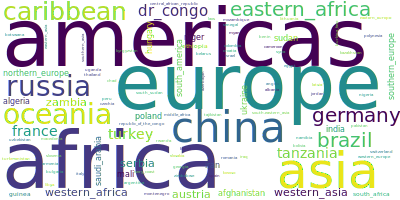

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from pykeen.datasets import Countries

# Load the dataset
dataset = Countries()

# Access the triples factory from the dataset
training = dataset.training

# Access the entity label mappings
entity_to_id = training.entity_word_cloud()
entity_to_id

##Graph visualisation

{40, 88, 253}


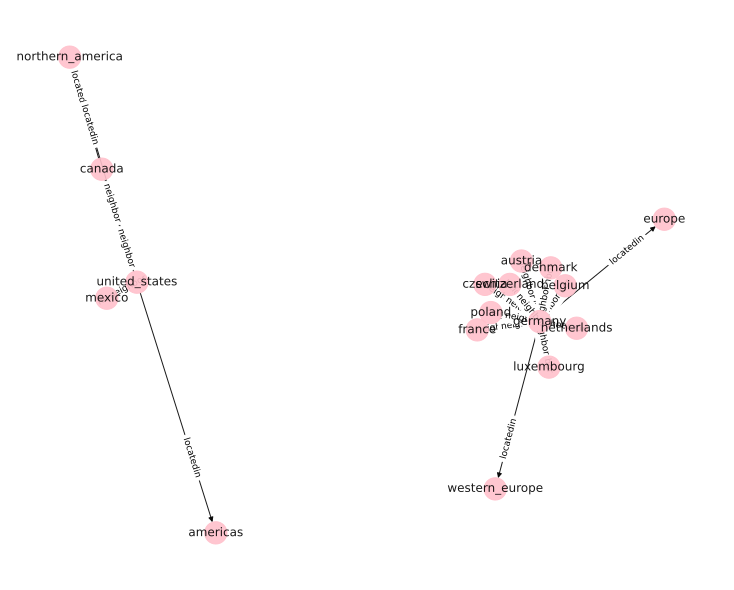

In [ ]:
# Note: Adjust this part based on how you access the entity and relation labels
entity_labels = training.entity_id_to_label
relation_labels = training.relation_id_to_label

# Specify the entities of interest by their labels
entities_of_interest = ['canada', 'united_states', 'germany']

# Convert entities of interest to their IDs using the inverse mapping
# Ensure we only consider entities actually present in the dataset
entities_of_interest_ids = {
    entity_id
    for entity_id, entity_label in entity_labels.items()
    if entity_label in entities_of_interest
}
print(entities_of_interest_ids)

# Initialize an empty list to hold filtered triples
filtered_triples = []

# Iterate through the triples and filter
for head_id, relation_id, tail_id in training.mapped_triples.tolist():
    if head_id in entities_of_interest_ids or tail_id in entities_of_interest_ids:
        # Convert IDs back to labels
        head_label = entity_labels[head_id]
        relation_label = relation_labels[relation_id]
        tail_label = entity_labels[tail_id]

        # Append the labeled triple to the list
        filtered_triples.append((head_label, relation_label, tail_label))

# Create a directed graph from the filtered triples
G = nx.DiGraph()
for head, relation, tail in filtered_triples:
    G.add_edge(head, tail, label=relation)

# Visualization
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='pink', alpha=0.9,
        labels={node: node for node in G.nodes()})
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['label'] for u, v, d in G.edges(data=True)},
                             label_pos=0.3, font_size=9)
plt.axis('off')
plt.show()

##Node embedding

In [ ]:
# Define and run the pipeline with a model and dataset of your choice
result = pipeline(
    model='DistMult',
    dataset='Countries',  # Example dataset
    training_kwargs=dict(num_epochs=5),  # Keep the training short for the example
)

# Access the trained model
model = result.model

# Get the entity_to_id mapping from the dataset's training triples factory
entity_to_id = result.training.entity_to_id

# Example: Get the ID for a specific entity ('uk' in this example, adjust as necessary)
entity_name = 'canada'  # Ensure this entity is present in your dataset
entity_id = entity_to_id[entity_name]  # Get the numerical ID corresponding to the entity name

# Access the embedding for this entity ID using the model
# Ensure that you are accessing the correct embedding layer (entity_representations[0] by default)
entity_embedding = model.entity_representations[0](indices=torch.tensor([entity_id])).detach().numpy()

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/countries/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: None


Training epochs on cpu:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0/5 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/24.0 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds


In [ ]:
print(f"Embedding for entity '{entity_name}' (ID: {entity_id}): {entity_embedding}")

Embedding for entity 'canada' (ID: 40): [[ 0.17802557 -0.16823272 -0.03718535  0.07913607  0.00346344  0.12176885
   0.17193025 -0.12456225  0.07018243 -0.01170578 -0.25568324  0.08817039
  -0.16285187 -0.16297275  0.09256671  0.19172062 -0.2449027   0.18625258
  -0.08069692 -0.1469621   0.16494061  0.08463258 -0.01559413  0.09262297
   0.06143944 -0.11025596  0.1185361   0.0773323  -0.21532562 -0.04323206
   0.00266731 -0.1957993  -0.06189004  0.22847344  0.0981436   0.21506177
   0.01365899 -0.15847312 -0.18535104 -0.15741658  0.2196791   0.23110728
  -0.07809878 -0.02117756 -0.16489257  0.04725834  0.10752661  0.24537101
   0.01724822 -0.03553398]]


#DistMult

##DistMult with Kadlec hyperparams

###Model

In [16]:
'''
The key part of the sampler's behavior is defined in the sample method,
which generates a fixed number of negative samples (self.num_samples) for each call,
regardless of the input batch size. This is achieved by repeating the positive batch
as necessary to match the desired number of negative samples and then altering
either the head or tail entity (based on a random choice)
for each negative sample to create the negative triples.
'''

from pykeen.sampling import NegativeSampler

class FixedSizeBatchNegativeSampler(NegativeSampler):
    def __init__(self, **kwargs):
        self.num_entities = kwargs.pop('num_entities', 1)  # Default to 1 if not provided
        self.num_samples = kwargs.pop('num_samples', 1000)  # Default to 1000 if not provided
        super().__init__(**kwargs)

    def sample(self, positive_batch: torch.LongTensor):
        batch_size, triple_size = positive_batch.shape

        head_or_tail = torch.randint(0, 2, (self.num_samples,))
        random_entities = torch.randint(0, self.num_entities, (self.num_samples,))

        negative_batch = positive_batch.new_empty((self.num_samples, triple_size))
        template_batch = positive_batch.repeat(self.num_samples // batch_size + 1, 1)[:self.num_samples]
        negative_batch[:, :] = template_batch

        for i in range(self.num_samples):
            if head_or_tail[i] == 0:
                negative_batch[i, 0] = random_entities[i]
            else:
                negative_batch[i, 2] = random_entities[i]

        # Assuming all negative samples are valid, we create a mask of ones
        masks = torch.ones(self.num_samples, dtype=torch.bool)

        return negative_batch, masks

In [17]:
distMult_pipeline = pipeline(
    dataset='WN18',
    model='DistMult',
    model_kwargs=dict(embedding_dim=256,
                      entity_initializer="xavier_uniform",
                      relation_initializer="xavier_uniform",
                      entity_constrainer="normalize"),
    training_loop='SLCWA',
    training_kwargs=dict(num_epochs=100, batch_size=1024),
    regularizer='LpRegularizer',
    regularizer_kwargs=dict(p=2,
                            weight=0.0,
                            apply_only_once=False,
                            normalize=False),
    random_seed=42,
    optimizer='Adam',
    optimizer_kwargs=dict(lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0),
    loss='NegativeLogLikelihoodLoss',
    loss_kwargs=dict(
        reduction="mean",  # Reduction method to apply to the output
    ),

    negative_sampler=FixedSizeBatchNegativeSampler,  # Use the class name as a string

    # negative_sampler_kwargs=dict(
    #      num_entities=1,
    #      num_samples=7
    # ),
    # evaluator_kwargs=dict(
    #                   filtered=True,
    #                   additional_metrics=['hits@10']  # Assuming you want to use hits@10
    # ),

    # negative_sampler='basic',
    # negative_sampler_kwargs=dict(
    #     num_negs_per_pos=2
    # ),

    device='gpu',
    stopper='early',
    stopper_kwargs=dict(
                  patience=5,
                  frequency=10,
                  relative_delta=0.001,
                  metric='hits@10',
                  ),
)

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-38a80f34-4303-4131-b1d2-611e36d8fabe.pt


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.9081. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-38a80f34-4303-4131-b1d2-611e36d8fabe.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.12s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.18s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.18s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.57s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.19s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 60. The best result 0.9081 occurred at epoch 10.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /root/.data/pykeen/checkpoints/best-model-weights-38a80f34-4303-4131-b1d2-611e36d8fabe.pt


Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.10s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='bcewithlogits Loss'>

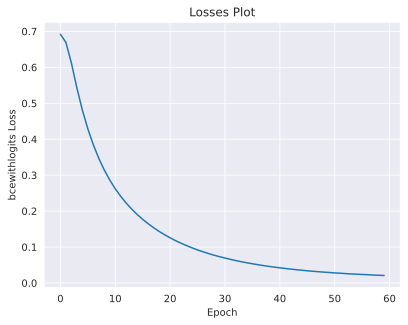

In [20]:
distMult_pipeline.plot_losses()

### Metrics

In [21]:
# Get Hits@10
hits_at_10 = distMult_pipeline.metric_results.get_metric('hits_at_k')
print(f"Hits@10: {hits_at_10}")

# For Mean Rank (MR) and Mean Reciprocal Rank (MRR)
mean_rank = distMult_pipeline.metric_results.get_metric('mean_rank')
mean_reciprocal_rank = distMult_pipeline.metric_results.get_metric('mean_reciprocal_rank')
print(f"Mean Rank: {mean_rank}")
print(f"Mean Reciprocal Rank: {mean_reciprocal_rank}")

Hits@10: 0.9108
Mean Rank: 461.1243896484375
Mean Reciprocal Rank: 0.7685226798057556


In [35]:
print(distMult_pipeline.metric_results.metrics)

{'z_inverse_harmonic_mean_rank': <class 'pykeen.metrics.ranking.ZInverseHarmonicMeanRank'>, 'adjusted_arithmetic_mean_rank': <class 'pykeen.metrics.ranking.AdjustedArithmeticMeanRank'>, 'count': <class 'pykeen.metrics.ranking.Count'>, 'standard_deviation': <class 'pykeen.metrics.ranking.StandardDeviation'>, 'hits_at_10': <class 'pykeen.metrics.ranking.HitsAtK'>, 'arithmetic_mean_rank': <class 'pykeen.metrics.ranking.ArithmeticMeanRank'>, 'median_rank': <class 'pykeen.metrics.ranking.MedianRank'>, 'z_arithmetic_mean_rank': <class 'pykeen.metrics.ranking.ZArithmeticMeanRank'>, 'harmonic_mean_rank': <class 'pykeen.metrics.ranking.HarmonicMeanRank'>, 'adjusted_geometric_mean_rank_index': <class 'pykeen.metrics.ranking.AdjustedGeometricMeanRankIndex'>, 'inverse_harmonic_mean_rank': <class 'pykeen.metrics.ranking.InverseHarmonicMeanRank'>, 'median_absolute_deviation': <class 'pykeen.metrics.ranking.MedianAbsoluteDeviation'>, 'z_geometric_mean_rank': <class 'pykeen.metrics.ranking.ZGeometricM

In [41]:
!pykeen experiments reproduce distmult yang2014 wn18

Running configuration at /usr/local/lib/python3.10/dist-packages/pykeen/experiments/distmult/yang2014_distmult_wn18.json
2024-03-13 06:13:41 WARNING  Trying to fix malformed key=hits_at_k.unknown.10 to key=hits_at_k.10 (error: Invalid metric name: hits_at_k.unknown.10)
2024-03-13 06:13:41 WARNING  Trying to fix malformed key=mean_reciprocal_rank.unknown to key=mean_reciprocal_rank (error: Invalid metric name: mean_reciprocal_rank.unknown)
2024-03-13 06:13:41 INFO     Running: Learn WN18 Dataset with DistMult as described by Yang et al., 2014
2024-03-13 06:13:41 WARNING  No random seed is specified. Setting to 1238688676.
2024-03-13 06:13:41 INFO     Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
2024-03-13 06:13:41 INFO     Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
2024-03-13 06:13:41 INFO     Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DE

## DistMult WN18 with different loss function
(Kadlec) NegativeLogLikelihoodLoss -> (Yang) MarginRankingLoss

In [9]:
from pykeen.sampling import NegativeSampler

class FixedSizeBatchNegativeSampler(NegativeSampler):
    def __init__(self, **kwargs):
        self.num_entities = kwargs.pop('num_entities', 1)  # Default to 1 if not provided
        self.num_samples = kwargs.pop('num_samples', 1000)  # Default to 1000 if not provided
        super().__init__(**kwargs)

    def sample(self, positive_batch: torch.LongTensor):
        batch_size, triple_size = positive_batch.shape

        head_or_tail = torch.randint(0, 2, (self.num_samples,))
        random_entities = torch.randint(0, self.num_entities, (self.num_samples,))

        negative_batch = positive_batch.new_empty((self.num_samples, triple_size))
        template_batch = positive_batch.repeat(self.num_samples // batch_size + 1, 1)[:self.num_samples]
        negative_batch[:, :] = template_batch

        for i in range(self.num_samples):
            if head_or_tail[i] == 0:
                negative_batch[i, 0] = random_entities[i]
            else:
                negative_batch[i, 2] = random_entities[i]

        # Assuming all negative samples are valid, we create a mask of ones
        masks = torch.ones(self.num_samples, dtype=torch.bool)

        return negative_batch, masks

In [11]:
distMult_pipeline = pipeline(
    dataset='WN18',
    model='DistMult',
    model_kwargs=dict(embedding_dim=256,
                      entity_initializer="xavier_uniform",
                      relation_initializer="xavier_uniform",
                      entity_constrainer="normalize"),
    training_loop='SLCWA',
    training_kwargs=dict(num_epochs=300, batch_size=1024),
    regularizer='LpRegularizer',
    regularizer_kwargs=dict(p=2,
                            weight=0.0,
                            apply_only_once=False,
                            normalize=False),
    random_seed=42,
    optimizer='Adam',
    optimizer_kwargs=dict(lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0),

    loss='NegativeLogLikelihoodLoss',
    loss_kwargs=dict(
      reduction="mean",
      margin=1
    ),

    #negative_sampler=FixedSizeBatchNegativeSampler,  # Use the class name as a string

    # negative_sampler_kwargs=dict(
    #      num_entities=1,
    #      num_samples=7
    # ),
    # evaluator_kwargs=dict(
    #                   filtered=True,
    #                   additional_metrics=['hits@10']  # Assuming you want to use hits@10
    # ),

    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        num_negs_per_pos=2
    ),

    device='gpu',
    stopper='early',
    stopper_kwargs=dict(
                  patience=5,
                  frequency=10,
                  relative_delta=0.001,
                  metric='hits@10',
                  ),
)

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-2a088869-b6f4-4269-82b6-7f7dd240ec00.pt


Training epochs on cuda:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.56s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.9227. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-2a088869-b6f4-4269-82b6-7f7dd240ec00.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.14s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.937. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-2a088869-b6f4-4269-82b6-7f7dd240ec00.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.11s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.52s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.15s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.15s seconds


Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/139 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.16s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 70. The best result 0.937 occurred at epoch 20.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /root/.data/pykeen/checkpoints/best-model-weights-2a088869-b6f4-4269-82b6-7f7dd240ec00.pt


Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 6.13s seconds


Hits@10: 0.9465
Mean Rank: 482.2467956542969
Mean Reciprocal Rank: 0.8418315649032593


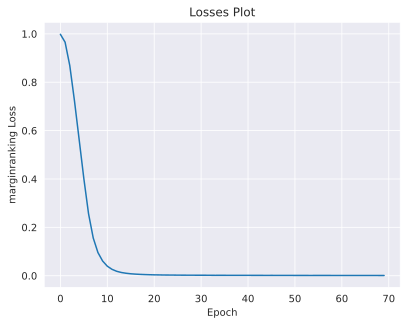

In [12]:
distMult_pipeline.plot_losses()

# Get Hits@10
hits_at_10 = distMult_pipeline.metric_results.get_metric('hits_at_k')
print(f"Hits@10: {hits_at_10}")

# For Mean Rank (MR) and Mean Reciprocal Rank (MRR)
mean_rank = distMult_pipeline.metric_results.get_metric('mean_rank')
mean_reciprocal_rank = distMult_pipeline.metric_results.get_metric('mean_reciprocal_rank')
print(f"Mean Rank: {mean_rank}")
print(f"Mean Reciprocal Rank: {mean_reciprocal_rank}")

##DistMult experiment hyperparams but with NegativeLogLos function


In [14]:
pipeline_config = pipeline(
    dataset='wn18',  # Dataset name corrected to match case sensitivity
    model='DistMult',  # Model name kept as is
    model_kwargs=dict(
        embedding_dim=100,  # Specified embedding dimension
        entity_initializer="xavier_uniform",  # Entity initializer method
        relation_initializer="xavier_uniform",  # Relation initializer method
        entity_constrainer="normalize"  # Entity constrainer method
    ),
    training_loop='SLCWA',  # Training loop method
    training_kwargs=dict(
        num_epochs=300,  # Number of training epochs
        batch_size=48310  # Batch size for training
    ),
    regularizer='Lp',  # Regularizer method
    regularizer_kwargs=dict(
        p=2.0,  # Norm order
        weight=0.0001,  # Regularization weight
        apply_only_once=False,  # Whether to apply regularization only once
        normalize=False  # Whether to normalize during regularization
    ),
    optimizer='Adagrad',  # Optimizer method
    optimizer_kwargs=dict(
        lr=0.1  # Learning rate for the optimizer
    ),

    loss='NegativeLogLikelihoodLoss',  # Loss function
    loss_kwargs=dict(
        reduction="mean",  # Reduction method to apply to the output
    ),

    negative_sampler='basic',  # Negative sampling method
    negative_sampler_kwargs=dict(
        num_negs_per_pos=2  # Number of negative samples per positive sample
    ),
    evaluator_kwargs=dict(
        filtered=True  # Whether to apply filtered setting in evaluation
    ),
    # Additional components based on the template provided:
    device='gpu',  # Specifies the device to use for computation
    stopper='early',  # Early stopping method
    stopper_kwargs=dict(
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        frequency=10,  # The frequency (in epochs) at which the stopping criterion is evaluated
        relative_delta=0.001,  # Minimum change in the monitored quantity to qualify as an improvement
        metric='hits@10',  # Evaluation metric for early stopping
    )
)


INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/wn18/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-c016b1cd-e2aa-4e6a-9a40-d865c43647d1.pt


Training epochs on cuda:0:   0%|          | 0/300 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.49s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.7825. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-c016b1cd-e2aa-4e6a-9a40-d865c43647d1.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.42s seconds


Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.85s seconds


Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.49s seconds


Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.42s seconds


Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/3 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.47s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 60. The best result 0.7825 occurred at epoch 10.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /root/.data/pykeen/checkpoints/best-model-weights-c016b1cd-e2aa-4e6a-9a40-d865c43647d1.pt


Evaluating on cuda:0:   0%|          | 0.00/5.00k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 3.45s seconds


Hits@10: 0.9465
Mean Rank: 482.2467956542969
Mean Reciprocal Rank: 0.8418315649032593


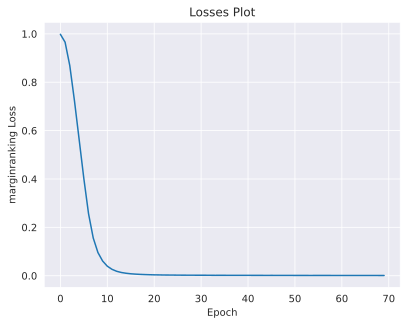

In [15]:
distMult_pipeline.plot_losses()

# Get Hits@10
hits_at_10 = distMult_pipeline.metric_results.get_metric('hits_at_k')
print(f"Hits@10: {hits_at_10}")

# For Mean Rank (MR) and Mean Reciprocal Rank (MRR)
mean_rank = distMult_pipeline.metric_results.get_metric('mean_rank')
mean_reciprocal_rank = distMult_pipeline.metric_results.get_metric('mean_reciprocal_rank')
print(f"Mean Rank: {mean_rank}")
print(f"Mean Reciprocal Rank: {mean_reciprocal_rank}")

##DistMult on FB15k

In [22]:
from pykeen.sampling import NegativeSampler

class FixedSizeBatchNegativeSampler(NegativeSampler):
    def __init__(self, **kwargs):
        self.num_entities = kwargs.pop('num_entities', 1)  # Default to 1 if not provided
        self.num_samples = kwargs.pop('num_samples', 2000)  # Default to 1000 if not provided
        super().__init__(**kwargs)

    def sample(self, positive_batch: torch.LongTensor):
        batch_size, triple_size = positive_batch.shape

        head_or_tail = torch.randint(0, 2, (self.num_samples,))
        random_entities = torch.randint(0, self.num_entities, (self.num_samples,))

        negative_batch = positive_batch.new_empty((self.num_samples, triple_size))
        template_batch = positive_batch.repeat(self.num_samples // batch_size + 1, 1)[:self.num_samples]
        negative_batch[:, :] = template_batch

        for i in range(self.num_samples):
            if head_or_tail[i] == 0:
                negative_batch[i, 0] = random_entities[i]
            else:
                negative_batch[i, 2] = random_entities[i]

        # Assuming all negative samples are valid, we create a mask of ones
        masks = torch.ones(self.num_samples, dtype=torch.bool)

        return negative_batch, masks

In [34]:
distMult_fb15_pipeline = pipeline(
    dataset='FB15k',
    model='DistMult',
    model_kwargs=dict(embedding_dim=512,
                      entity_initializer="xavier_uniform",
                      relation_initializer="xavier_uniform",
                      entity_constrainer="normalize"),
    training_loop='SLCWA',
    training_kwargs=dict(num_epochs=100, batch_size=2048),
    regularizer='LpRegularizer',
    regularizer_kwargs=dict(p=2,
                            weight=0.0,
                            apply_only_once=False,
                            normalize=False),
    random_seed=42,
    optimizer='Adam',
    optimizer_kwargs=dict(lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0),
    loss='NegativeLogLikelihoodLoss',

    #negative_sampler=FixedSizeBatchNegativeSampler,
    # evaluator_kwargs=dict(
    #                   filtered=True,
    #                   additional_metrics=['hits@10']  # Assuming you want to use hits@10
    # ),

    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        num_negs_per_pos=2
    ),

    device='gpu',
    stopper='early',
    stopper_kwargs=dict(
                  patience=5,
                  frequency=10,
                  relative_delta=0.001,
                  metric='hits@10',
                  ),
)

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/fb15k/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/fb15k/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/fb15k/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///root/.data/pykeen/datasets/fb15k/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.12s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.26488. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 20: 0.29026. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 20.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.04s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 30: 0.33536. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 30.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.02s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 40: 0.3736. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 40.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.16s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.40855. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.01s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 60: 0.43981. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 60.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.55s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 70: 0.47309. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 70.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.02s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 80: 0.50395. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 80.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.94s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 90: 0.52829. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 90.


Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/236 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/50.0k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 51.17s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 100: 0.5469. Saved model weights to /root/.data/pykeen/checkpoints/best-model-weights-3bc5d02d-4543-4500-b43d-0269b728ddf6.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 100.


Evaluating on cuda:0:   0%|          | 0.00/59.1k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 61.57s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='bcewithlogits Loss'>

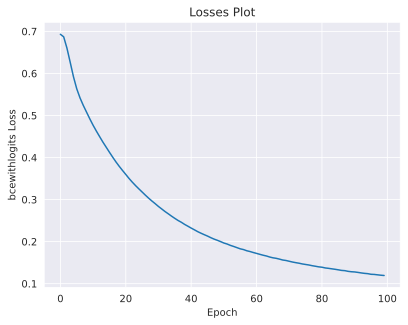

In [36]:
distMult_fb15_pipeline.plot_losses()

In [37]:
# Get Hits@10
hits_at_10 = distMult_fb15_pipeline.metric_results.get_metric('hits_at_k')
print(f"Hits@10: {hits_at_10}")

# For Mean Rank (MR) and Mean Reciprocal Rank (MRR)
mean_rank = distMult_fb15_pipeline.metric_results.get_metric('mean_rank')
mean_reciprocal_rank = distMult_fb15_pipeline.metric_results.get_metric('mean_reciprocal_rank')
print(f"Mean Rank: {mean_rank}")
print(f"Mean Reciprocal Rank: {mean_reciprocal_rank}")

Hits@10: 0.5834588884562645
Mean Rank: 75.99980163574219
Mean Reciprocal Rank: 0.3550897240638733


Hits@10: 0.5467911496334918
Mean Rank: 82.29983520507812
Mean Reciprocal Rank: 0.32257360219955444

In [39]:
!pykeen experiments reproduce distmult yang2014 fb15k

Running configuration at /usr/local/lib/python3.10/dist-packages/pykeen/experiments/distmult/yang2014_distmult_fb15k.json
2024-03-13 05:39:00 WARNING  Trying to fix malformed key=hits_at_k.unknown.10 to key=hits_at_k.10 (error: Invalid metric name: hits_at_k.unknown.10)
2024-03-13 05:39:00 WARNING  Trying to fix malformed key=mean_reciprocal_rank.unknown to key=mean_reciprocal_rank (error: Invalid metric name: mean_reciprocal_rank.unknown)
2024-03-13 05:39:00 INFO     Running: Learn FB15K Dataset with DistMult as described by Yang et al., 2014
2024-03-13 05:39:00 WARNING  No random seed is specified. Setting to 3505688357.
2024-03-13 05:39:00 INFO     Loading cached preprocessed dataset from file:///root/.data/pykeen/datasets/fb15k/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
2024-03-13 05:39:00 INFO     Loading from file:///root/.data/pykeen/datasets/fb15k/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
2024-03-13 05:39:00 INFO     Loading from file:///root/.data/pykeen/datasets/fb15k/cache

#TransE

Do not run on colab. It will die

In [ ]:
#pykeen experiments reproduce transe bordes2013 wn18  -d '/content/drive/MyDrive/UViC/Knowledge graph embedding/TransE' > /dev/null